<a href="https://colab.research.google.com/github/aborundiya/CNN/blob/master/openai_food101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is classification of food - 101 food datasets to achieve the Top-1 accuracy > 85% with ResNet50 and lower architecture 

In [0]:
import warnings 
warnings.filterwarnings("ignore")

In [0]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import copy 
import torch
import torch.nn as nn 
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
from collections import defaultdict 
import os
import copy
#from shutil import copy 



#Data Download and Splitting Training and Testing Data 
Dowaloaded the food-101 data set (Size ~ 5GB) on local machine 
1) Total Images : 101000 
2) Total Classes : 101 
Task
1) Split the images into train and test folders based list provided by the authors in train.txt and test.txt 
2) upload the dataset to gdrive to be able to work in colab and gain access to GPUs  

In [0]:
def prepare_data(filepath, src , dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')
  
  for food in classes_images.keys():
    print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
    
  print("Copying Done!")

In [0]:
#%cd /Users/sonalijain/Desktop/Amit/openai/food-101 

In [0]:
#prepare_data('./meta/train.txt', './images', 'train')

In [0]:
#prepare_data('./meta/test.txt', './images', 'test')

#Googdrive authentication and copying of the data set



1.   Initially the time for each epoch was very longs 3-5 hours/epoch as the fecthing of the images were happening from the gdrive. 

2.   The colab deletes all the files once the session is terminated or it gets terminated due to connectivity issues (which is presently prevalent at my location)
3) The colab allows you to upload only file and hence the Zip is uploaded and 
unziped in the session
4) I have had to use Colab as I am stuck at my native in India and don't have my high performace machine with me. 


In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import drive 

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
downloaded = drive.CreateFile({'id':"1GE6v1Ef9QR4R-SLo_oCx8dUORXvXRNFq"})   # replace the id with id of file you want to access
downloaded.GetContentFile('food-101.zip') 


In [7]:
!unzip food-101.zip

Streaming output truncated to the last 5000 lines.
  inflating: food-101/train/strawberry_shortcake/2245360.jpg  
  inflating: food-101/train/strawberry_shortcake/2259069.jpg  
  inflating: food-101/train/strawberry_shortcake/2259652.jpg  
  inflating: food-101/train/strawberry_shortcake/2266581.jpg  
  inflating: food-101/train/strawberry_shortcake/2271614.jpg  
  inflating: food-101/train/strawberry_shortcake/2275253.jpg  
  inflating: food-101/train/strawberry_shortcake/2282398.jpg  
  inflating: food-101/train/strawberry_shortcake/2282550.jpg  
  inflating: food-101/train/strawberry_shortcake/2288472.jpg  
  inflating: food-101/train/strawberry_shortcake/2291293.jpg  
  inflating: food-101/train/strawberry_shortcake/2292632.jpg  
  inflating: food-101/train/strawberry_shortcake/2300458.jpg  
  inflating: food-101/train/strawberry_shortcake/2302763.jpg  
  inflating: food-101/train/strawberry_shortcake/2307357.jpg  
  inflating: food-101/train/strawberry_shortcake/2312692.jpg  
  in

In [5]:
!pwd

/content


In [8]:
     
%cd /content/food-101                                    

/content/food-101


#Datasets

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [0]:


train_transforms = transforms.Compose([transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomVerticalFlip(),
                                       transforms.RandomRotation(45),
                                       transforms.RandomAffine(45),
                                       transforms.ColorJitter(),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])
valid_transforms =  transforms.Compose([transforms.RandomResizedCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.TenCrop(224),
                                      transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
                                      transforms.Lambda(lambda crops: torch.stack([transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])(crop) for crop in crops]))])


In [0]:
train_set = torchvision.datasets.ImageFolder("./train",transform=train_transforms)
test_set = torchvision.datasets.ImageFolder("./test",transform=test_transforms)
valid_set = torchvision.datasets.ImageFolder("./test",transform = valid_transforms)

In [16]:
!find /train -type d -or -type f -printf '.' | wc -c
!find /test  -type d -or -type f -printf '.' | wc -c

find: ‘/train’: No such file or directory
0
find: ‘/test’: No such file or directory
0


In [0]:
batch_size = 4
train_loader = torch.utils.data.DataLoader(train_set,batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=batch_size, shuffle=True)

reshaping helps to utilize the broadcast functionality provided

In [0]:
def imshow(img, title):
  nimg = img.numpy() / np.asarray([0.229, 0.224, 0.225]).reshape(3,1,1) + np.asarray([0.485, 0.456, 0.406]).reshape(3,1,1)
  plt.figure(figsize=(batch_size,1))
  plt.axis("off")
  plt.imshow(np.transpose(nimg,(1,2,0)))
  plt.title(title)
  plt.show()

In [0]:
def show_batch_images(dataloader):
  images, labels = iter(dataloader).next()
  img = torchvision.utils.make_grid(images)
  imshow(img, title=[str(x.item()) for x in labels ])

In [12]:
dataiter = iter(train_loader)
inputs, labels = dataiter.next()
print(inputs.shape)
print(labels[0].item())
print(inputs[0].shape)

dataiter = iter(test_loader)
inputs, labels = dataiter.next()
print(inputs.shape)
print(labels[0].item())
print(inputs[0].shape)

NameError: ignored

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


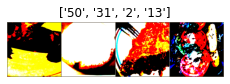

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


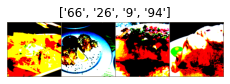

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


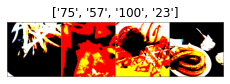

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


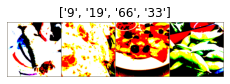

In [21]:
for i in range(4):
  show_batch_images(train_loader)

In [0]:

batch_size = 16 
train_loader = torch.utils.data.DataLoader(train_set,batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=batch_size,shuffle=False)
valid_loader = torch.utils.data.DataLoader(valid_set,batch_size=batch_size,shuffle=False )


In [13]:
dataiter = iter(train_loader)
inputs, labels = dataiter.next()
print(inputs.shape)
print(inputs[0].shape)
print(labels[0].item())

dataiter = iter(valid_loader)
inputs, labels = dataiter.next()
print(inputs.shape)
print(inputs[0].shape)
print(labels[0].item())

dataiter = iter(test_loader)
inputs, labels = dataiter.next()
print(inputs.shape)
print(inputs[0].shape)
print(inputs[0][0].shape)
print(labels[0].item())

torch.Size([16, 3, 224, 224])
torch.Size([3, 224, 224])
69
torch.Size([16, 3, 224, 224])
torch.Size([3, 224, 224])
0
torch.Size([16, 10, 3, 224, 224])
torch.Size([10, 3, 224, 224])
torch.Size([3, 224, 224])
0


#Since it is very expensive to load each time the images Set to the Colab hence saving the train_loader and test_loader 

One epoch on the local machine is around 10 hours
1) Try running with GPU on Colab
2) Buy more compute and check 
3) Downsize the problem and finanlize the approach 

In [0]:
#torch.save(train_loader,'train_loader.pt')
#torch.save(test_loader,'test_loader.pt')

# New Section

In [0]:
#train_loader = torch.load('train_loader.pt')
#test_loader = torch.load('test_loader.pt')

In [14]:
resnet = models.resnet50(pretrained=True)


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [0]:
for param in resnet.parameters():
  param.requires_grad = False 


In [0]:
num_classes = 101 
final_in_feature = resnet.fc.in_features
resnet.fc = nn.Linear(final_in_feature,num_classes)

In [17]:
for param in resnet.parameters():
  if param.requires_grad:    
    print(param.shape)

torch.Size([101, 2048])
torch.Size([101])


In [0]:
resnet = resnet.to(device)

In [0]:
def initialize_resnet(num_classes=101):
  resnet = models.resnet50(pretrained=False)
  #for param in resnet.parameters():
    #param.requires_grad = False 
  final_in_feature = resnet.fc.in_features
  resnet.fc = nn.Linear(final_in_feature,num_classes)
  return resnet

In [0]:
def evaluation(dataloader, model,test=False):
  total , correct = 0 , 0 
  for data in dataloader:

    inputs, labels = data 
    inputs, labels = inputs.to(device), labels.to(device)
    
    if test: 
      #For Multiclass classification TTA validations is summing all class probabilties for the TenCrop and choosing labels using argmax
      #For Regression it will be mean and label prediction it will be mode 
      bs, ncrops, c, h, w = inputs.size()
      outputs = model(inputs.view(-1, c, h, w)) # fuse batch size and ncrops
      outputs = outputs.view(bs, ncrops, -1).sum(1) # Sum over crop
      _ , pred = torch.max(outputs.data,1)
    else :
      outputs = model(inputs)
      _,pred = torch.max(outputs.data,1)
    
    total += labels.size(0)
    correct += (pred == labels).sum().item()
    del inputs, labels, outputs 
    torch.cuda.empty_cache()
  return 100 * (correct / total )

In [0]:
print(type(train_loader.dataset))

<class 'torchvision.datasets.folder.ImageFolder'>


In [25]:
%%time
batch_size = 16
loss_fn = nn.CrossEntropyLoss()
lr = [0.01]
weight_decay = [0.0001]
#momentum = [0.9]
function = [optim.Adam] #[optim.SGD] #, optim.Adagrad]
loss_arr_epoch = []
loss_valid = []
loss_train = []
 
max_epoch = 20
n_iter = np.ceil(75750/batch_size)

for i in range(len(lr)):
  #for j in range(len(momentum)):
    for k in range(len(function)):
      #resnet = initialize_resnet(num_classes=101)
      #resnet.to(device)
      opt = function[k](resnet.parameters(),lr=lr[i],momentum=0.9)
      #optim.SGD(resnet.parameters(),lr=0.01,momentum=0.9,nesterov=True)
      scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt,'min',patience=1,verbose=True,factor=0.9)
      print(function[k])
      print("For Function  : %s and For learning Rate : %f:" % (function[k], lr[i]))
      min_loss = np.inf
      valid_loss = 0 

      for epoch in range(max_epoch):
        resnet.train()
        loss_arr = 0
        for l , data in enumerate(train_loader,0):
          inputs, labels = data 
          inputs, labels = inputs.to(device), labels.to(device)
          opt.zero_grad()
          outputs = resnet(inputs)
          loss = loss_fn(outputs,labels)
          loss.backward()
          opt.step()
          if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(resnet.state_dict())
          loss_arr += loss.item()
            #print("Min Loss %0.2f"% min_loss)
          if l % 300 == 0 : 
            print("Epoch %d/%d, Loss : %0.2f, Min Loss : %0.2f, Valid Loss : %0.2f "  % (l, n_iter,loss.item(),min_loss,valid_loss))
          
          del inputs, labels, outputs 
          torch.cuda.empty_cache()
        scheduler.step(loss.item())
        loss_arr_epoch.append(loss.item())
        resnet.eval()
        training_acc = evaluation(train_loader,resnet)
        valid_acc = evaluation(valid_loader,resnet)
        print("Epoch : %d, Avg. Loss : %0.4f  Train Accuracy : %0.2f , Test Accuracy : %0.2f" % (epoch, (loss_arr)/len(train_loader.dataset), training_acc, valid_acc ))
        if valid_acc > valid_loss:
          valid_loss = valid_acc
          best_epoch_model = copy.deepcopy(resnet.state_dict())

        

<class 'torch.optim.sgd.SGD'>
For Function  : <class 'torch.optim.sgd.SGD'> and For learning Rate : 0.010000:
Epoch 0/4735, Loss : 3.10, Min Loss : 3.10, Valid Loss : 0.00 
Epoch 300/4735, Loss : 2.90, Min Loss : 1.23, Valid Loss : 0.00 
Epoch 600/4735, Loss : 2.85, Min Loss : 1.23, Valid Loss : 0.00 
Epoch 900/4735, Loss : 1.41, Min Loss : 1.07, Valid Loss : 0.00 
Epoch 1200/4735, Loss : 3.31, Min Loss : 1.07, Valid Loss : 0.00 
Epoch 1500/4735, Loss : 3.02, Min Loss : 1.07, Valid Loss : 0.00 
Epoch 1800/4735, Loss : 2.56, Min Loss : 1.07, Valid Loss : 0.00 
Epoch 2100/4735, Loss : 2.11, Min Loss : 1.07, Valid Loss : 0.00 
Epoch 2400/4735, Loss : 3.64, Min Loss : 1.07, Valid Loss : 0.00 
Epoch 2700/4735, Loss : 4.77, Min Loss : 1.07, Valid Loss : 0.00 
Epoch 3000/4735, Loss : 3.36, Min Loss : 1.07, Valid Loss : 0.00 
Epoch 3300/4735, Loss : 3.83, Min Loss : 1.07, Valid Loss : 0.00 
Epoch 3600/4735, Loss : 3.93, Min Loss : 1.07, Valid Loss : 0.00 
Epoch 3900/4735, Loss : 5.09, Min Loss

In [0]:
best_model = torch.load("../bestmodel.pt")

In [25]:
resnet.eval()
resnet.load_state_dict(best_model)
print("Train Accuracy : %0.2f" % (evaluation(train_loader,resnet)))
print("Test Accuracy", evaluation(test_loader,resnet,test=True))


Train Accuracy : 37.92
Test Accuracy 47.16435643564356


In [29]:
resnet.eval()
resnet.load_state_dict(best_epoch_model)
print("Epoch %d/%0.2f, Train Accuracy : %0.2f" % (epoch, min_loss, evaluation(train_loader,resnet)))
print("Test Accuracy", evaluation(test_loader,resnet,test=True))

Epoch 19/0.73, Train Accuracy : 43.46
Test Accuracy 53.83366336633664


In [0]:
def plot_weights(model, single_channel = True, collated = False):
    
    layer = model.conv1
    if isinstance(layer, nn.Conv2d):
        weight_tensor = layer.weight.data
        if single_channel:
            if collated:
                plot_filters_single_channel_big(weight_tensor)
            else:
                plot_filters_single_channel(weight_tensor)
        else:
            if weight_tensor.shape[1] == 3:
                plot_filters_multi_channel(weight_tensor)
            else:
                'Can only plot weights with three channels with single_channel = False'
    else:
        print('Can only visualise layers which are convolutional')

In [0]:
def plot_filters_multi_channel(t):
    
    num_kernels = t.shape[0]    
    
    num_cols = 12
    num_rows = num_kernels
    
    fig = plt.figure(figsize=(num_cols,num_rows))
    for i in range(t.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        
        npimg = np.array(t[i].numpy(), np.float32)
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])

    plt.tight_layout()
    plt.show()

In [0]:
def plot_filters_single_channel(t):
    
    nplots = t.shape[0]*t.shape[1]
    ncols = 12
    nrows = 1 + nplots//ncols
    
    npimg = np.array(t.numpy(), np.float32)
    
    count = 0
    
    fig = plt.figure(figsize=(ncols, nrows))
    for i in range(t.shape[0]):
        for j in range(t.shape[1]):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i, j].numpy(), np.float32)
            npimg = (npimg - np.mean(npimg)) / np.std(npimg)
            npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            ax1.imshow(npimg)
            ax1.set_title(str(i) + ',' + str(j))
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
   
    plt.tight_layout()
    plt.show()

In [0]:
def plot_filters_single_channel_big(t):
    
    nrows = t.shape[0]*t.shape[2]
    ncols = t.shape[1]*t.shape[3]
          
    npimg = np.array(t.numpy(), np.float32)
    npimg = npimg.transpose((0, 2, 1, 3))
    npimg = npimg.ravel().reshape(nrows, ncols)
    
    npimg = npimg.T
    
    fig, ax = plt.subplots(figsize=(ncols/10, nrows/200))    
    imgplot = sns.heatmap(npimg, xticklabels=False, yticklabels=False, cmap='Greys', ax=ax, cbar=False)

In [0]:
resnet = initialize_resnet(num_classes=101)

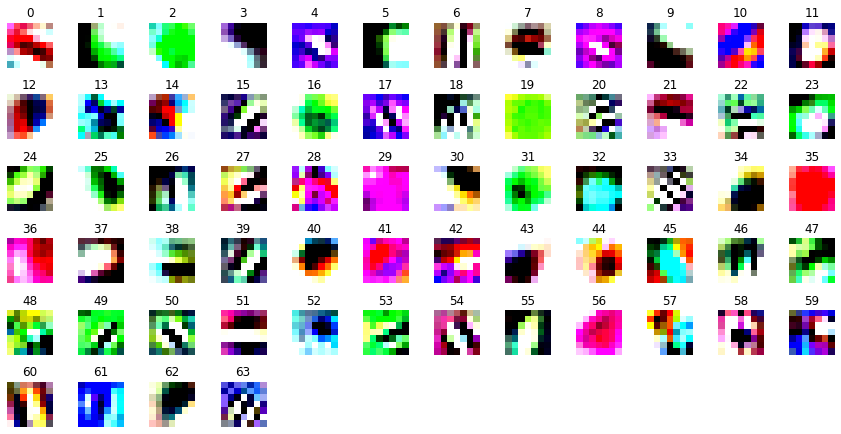

In [73]:
resnet.load_state_dict(best_model)
plot_weights(resnet,single_channel=False)

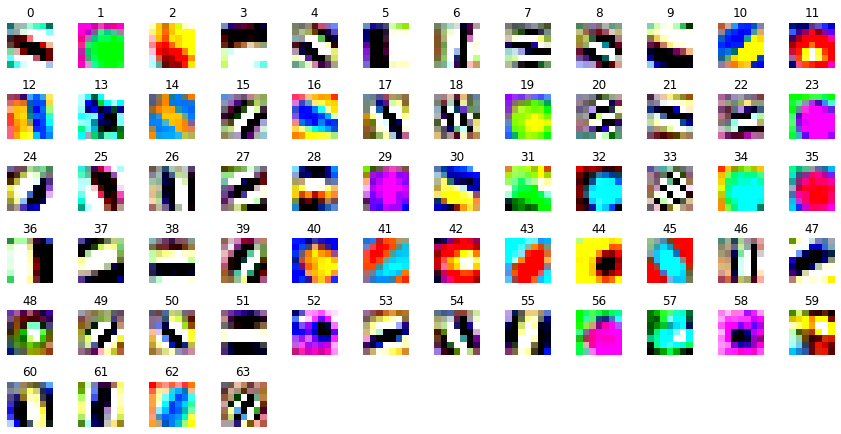

In [101]:
plot_weights(resnet_epoch,single_channel=False)

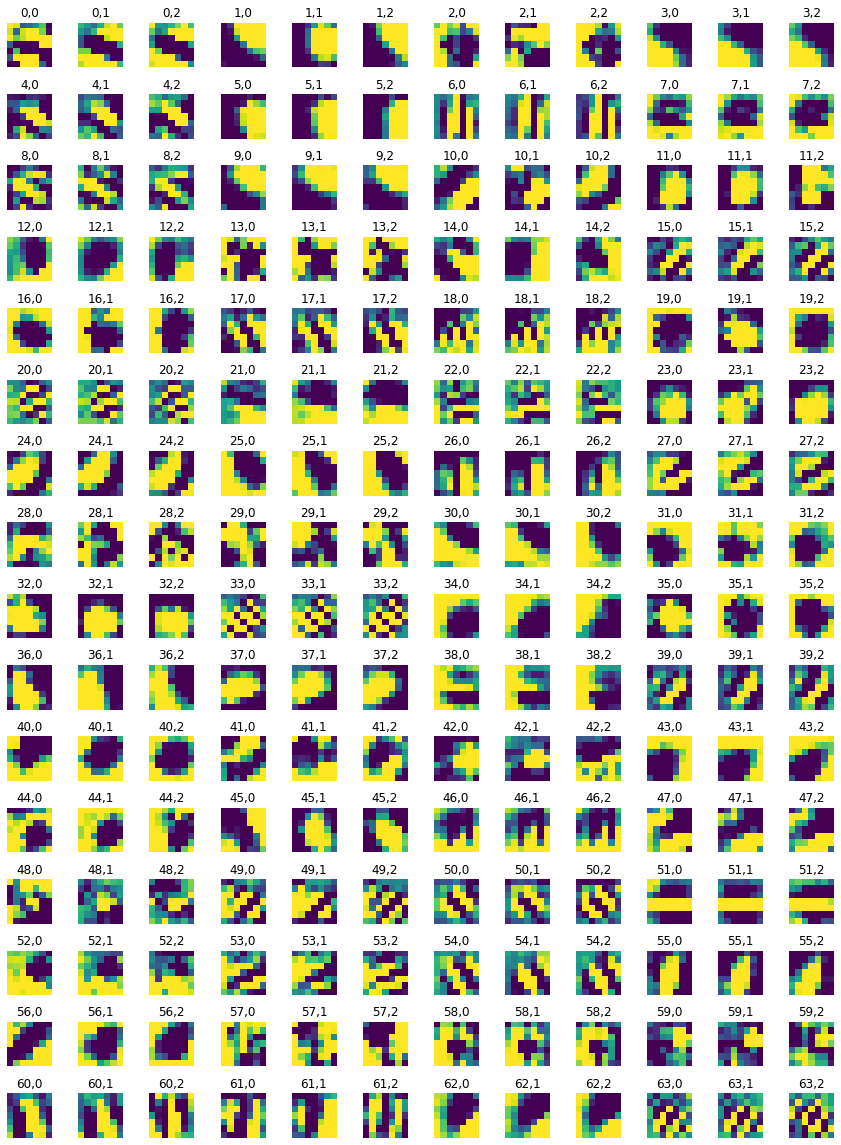

In [74]:
plot_weights(resnet,single_channel=True)

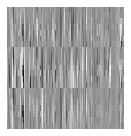

In [76]:
plot_weights(resnet,single_channel=True, collated=True )

(64, 3, 7, 7)


[]

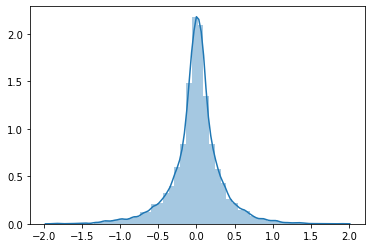

In [88]:

weight_layer0 = list(resnet.parameters())[0].data.numpy()
print(weight_layer0.shape)
sns.distplot(weight_layer0.ravel())
plt.plot()

In [0]:
resnet_epoch = initialize_resnet()

In [94]:
best_epoch_model = torch.load("../bestmodel77.pt")
resnet_epoch.load_state_dict(best_epoch_model)

<All keys matched successfully>

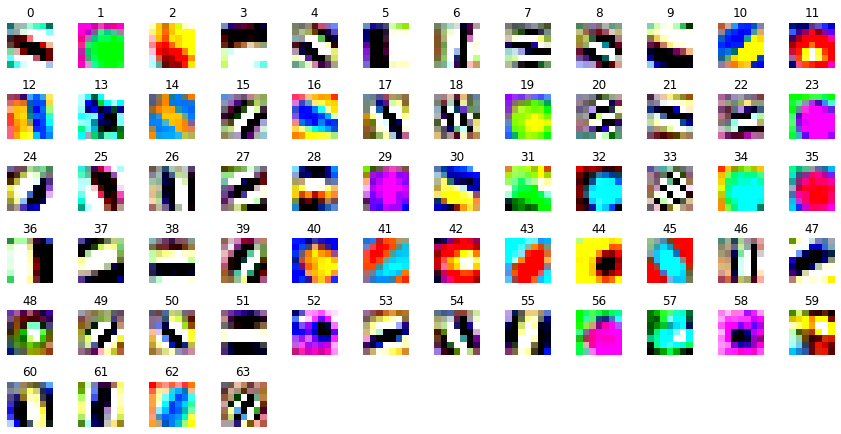

In [95]:
plot_weights(resnet_epoch,single_channel=False)

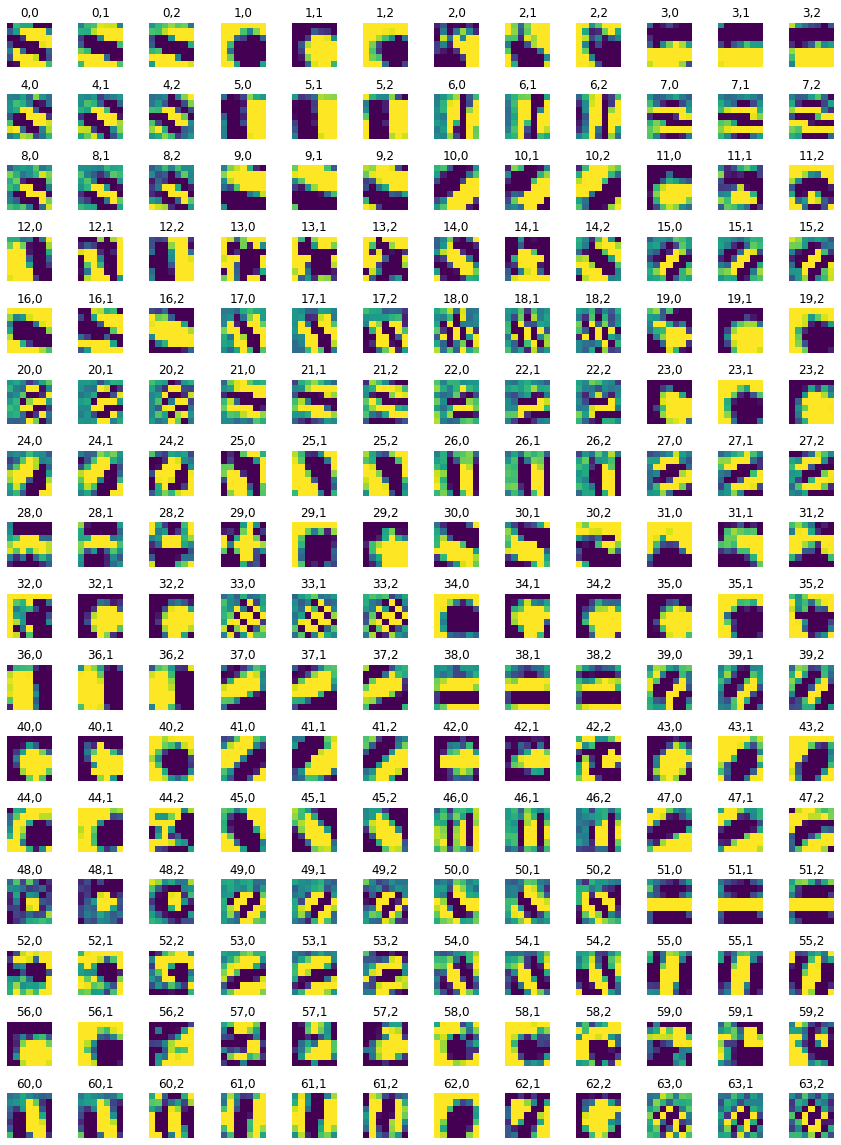

In [98]:
plot_weights(resnet_epoch,single_channel=True)

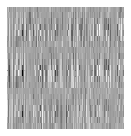

In [99]:
plot_weights(resnet_epoch,single_channel=True, collated=True )

(64, 3, 7, 7)


[]

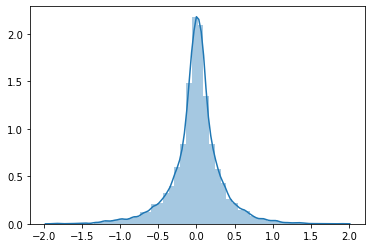

In [100]:

weight_layer0 = list(resnet.parameters())[0].data.numpy()
print(weight_layer0.shape)
sns.distplot(weight_layer0.ravel())
plt.plot()

In [0]:
resnet = initialize_resnet(num_classes=101)

In [38]:
best_epoch_model = torch.load("../bestepochmodelSGD77.pt")
resnet.load_state_dict(best_epoch_model)

<All keys matched successfully>

In [3]:

batch_size = 16
loss_fn = nn.CrossEntropyLoss()
lr = [0.01]
weight_decay = [0.0001]
#momentum = [0.9]
function = [optim.SGD] 
loss_arr_epoch = []
max_epoch = 20
n_iter = np.ceil(75750/batch_size)
resnet.to(device)
resnet.load_state_dict(best_epoch_model)
for i in range(len(lr)):
  #for j in range(len(momentum)):
    for k in range(len(function)):
      #resnet = initialize_resnet(num_classes=101)
      #resnet.to(device)
      opt = function[k](resnet.parameters(),lr=lr[i],momentum=0.9)
      scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt,'min',patience=1,verbose=True,factor=0.9)
      min_loss = np.inf 
      valid_loss = 0 
      print(function[k])
      print("For Function  : %s and For learning Rate : %f:" % (function[k], lr[i]))
      min_loss = 1000

      for epoch in range(max_epoch):
        resnet.train()
        loss_arr = 0 
        for l , data in enumerate(train_loader,0):
          inputs, labels = data 
          inputs, labels = inputs.to(device), labels.to(device)
          opt.zero_grad()
          outputs = resnet(inputs)
          loss = loss_fn(outputs,labels)
          loss.backward()
          opt.step()
          if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(resnet.state_dict())
            #print("Min Loss %0.2f"% min_loss)
          if l % 300 == 0 : 
            print("Epoch %d/%d, Loss : %0.2f, Min Loss : %0.2f"  % (l, n_iter,loss.item(),min_loss))
          loss_arr += loss.item()
          loss_arr_epoch.append(loss.item())
          del inputs, labels, outputs 
          torch.cuda.empty_cache()

        scheduler.step(loss.item())
        resnet.eval()
        training_acc = evaluation(train_loader,resnet)
        valid_acc = evaluation(valid_loader,resnet)
        print("Epoch : %d, Avg. Loss : %0.4f  Train Accuracy : %0.2f , Test Accuracy : %0.2f" % (epoch, (loss_arr)/len(train_loader.dataset), training_acc, valid_acc ))
        if valid_acc > valid_loss:
          valid_loss = valid_acc
          best_epoch_model = copy.deepcopy(resnet.state_dict())


NameError: ignored

In [0]:
torch.save(best_model, "bestmodel1806.pt")

In [1]:
torch.save(best_epoch_model,"bestepochmodelSGD1806.pt")

NameError: ignored

In [2]:
from google.colab import files
files.download("bestmodel1806.pt")
files.download("bestepochmodelSGD1806.pt")

FileNotFoundError: ignored

In [0]:
 torch.cuda.empty_cache()

In [0]:
resnet.eval()
resnet.load_state_dict(best_model)
print("Epoch %d/%0.2f, Train Accuracy : %0.2f" % (epoch, min_loss, evaluation(train_loader,resnet)))
print("Test Accuracy", evaluation(test_loader,resnet,test=True))

In [0]:
resnet.eval()
resnet.load_state_dict(best_epoch_model)
print("Epoch %d/%0.2f, Train Accuracy : %0.2f" % (epoch, min_loss, evaluation(train_loader,resnet)))
print("Test Accuracy", evaluation(test_loader,resnet,test=True))